<a href="https://colab.research.google.com/github/woosukji/snu-lectures/blob/main/%2022-2_intro-to-nlp/Analysis_on_Ripple_Pattern_in_Document_Term_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis on Ripple Pattern in Document-Term Matrix

### 22-F Introduction to NLP

### 수리과학부 지우석

## Preparations

In [110]:
# This tutorial was based on a specific version of fastai
!pip install fastai==1.0.61
!pip install spacy==2.3.5
!python -m spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 15.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [111]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.utils.mem import GPUMemTrace #call with mtrace

import sklearn.feature_extraction.text as sklearn_text
import pickle 

In [112]:
path = untar_data(URLs.IMDB_SAMPLE)
path

PosixPath('/root/.fastai/data/imdb_sample')

In [113]:
%%time
# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!

count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text')
                         .split_from_df(col=2)
                        # .split_none()
                         .label_from_df(cols=0))
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


failure count is 0

CPU times: user 221 ms, sys: 101 ms, total: 322 ms
Wall time: 3.5 s


## Recap on the Problem

In [114]:
print(f'There are {len(movie_reviews.train.x)} and {len(movie_reviews.valid.x)} reviews in the training and validations sets, respectively.')

There are 800 and 200 reviews in the training and validations sets, respectively.


In [115]:
print(f'There are {len(movie_reviews.vocab.itos)} unique tokens in the IMDb review sample vocabulary')
print(f'The numericalized token values run from {min(movie_reviews.vocab.stoi.values())} to {max(movie_reviews.vocab.stoi.values())} ')

There are 6008 unique tokens in the IMDb review sample vocabulary
The numericalized token values run from 0 to 6007 


In [116]:
n_terms = len(movie_reviews.vocab.itos)
n_docs = len(movie_reviews.train.x)
make_token_counter = lambda review_index: Counter(movie_reviews.train.x[review_index].data)
def count_vectorizer(review_index,n_terms = n_terms,make_token_counter = make_token_counter):
    # input: review index, n_terms, and tokenizer function
    # output: embedding vector for the review
    embedding_vector = np.zeros(n_terms)        
    keys = list(make_token_counter(review_index).keys())
    values = list(make_token_counter(review_index).values())
    embedding_vector[keys] = values
    return embedding_vector

# make the embedding vector for the first review
embedding_vector = count_vectorizer(0)

In [117]:
print(f'The review is embedded in a {len(embedding_vector)} dimensional vector')
embedding_vector

The review is embedded in a 6008 dimensional vector


array([8., 0., 1., 0., ..., 0., 0., 0., 0.])

In [118]:
# Define a function to build the full document-term matrix
print(f'there are {n_docs} reviews, and {n_terms} unique tokens in the vocabulary')
def make_full_doc_term_matrix(count_vectorizer,n_terms=n_terms,n_docs=n_docs):
    
    # loop through the movie reviews
    for doc_index in range(n_docs):
        
        # make the embedding vector for the current review
        embedding_vector = count_vectorizer(doc_index,n_terms)    
            
        # append the embedding vector to the document-term matrix
        if(doc_index == 0):
            A = embedding_vector
        else:
            A = np.vstack((A,embedding_vector))
            
    # return the document-term matrix
    return A

# Build the full document term matrix for the movie_reviews training set
A = make_full_doc_term_matrix(count_vectorizer)

there are 800 reviews, and 6008 unique tokens in the vocabulary


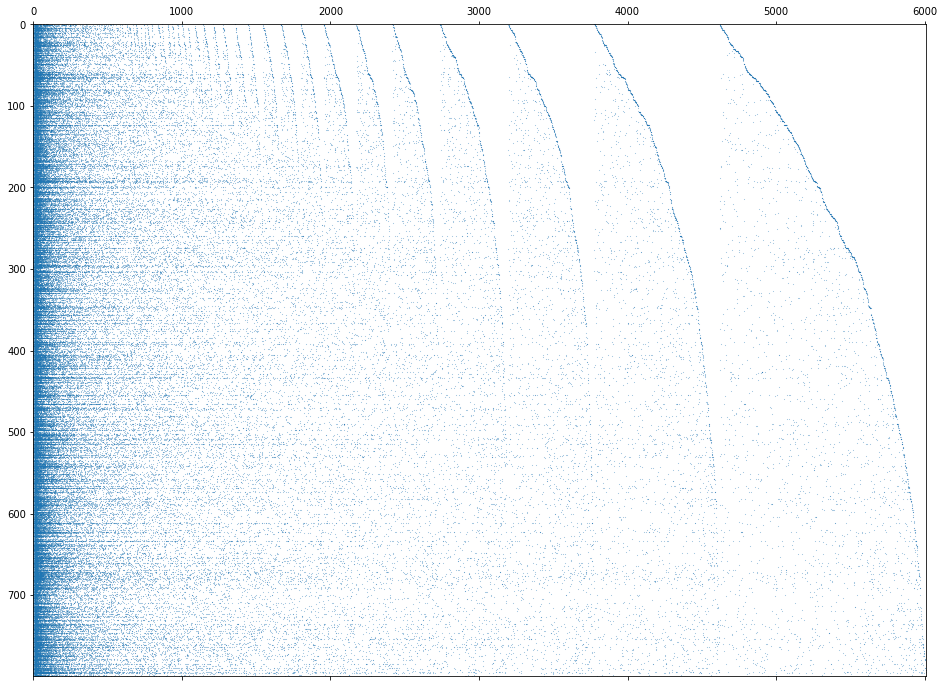

In [119]:
fig = plt.figure()
plt.spy(A, markersize=0.10, aspect = 'auto')
fig.set_size_inches(16,12)
# fig.savefig('doc_term_matrix.png', dpi=800)

#### In the visualization of document-term matrix, there definitely arises a ripple-like pattern of density. Let's further analyze underlying behaviour of the data.

## Analysis

#### When we plot vertical sum of `A` (`axis=0`), which stands for the \# of occurrences for each token throughout the whole (training) data, we see a decreasing, extreme long-tail distribution.

#### This pattern is well-justified, since when Fastai's preprocessing API tokenizes a corpus, the resulting token index is sorted by a \# of occurence.


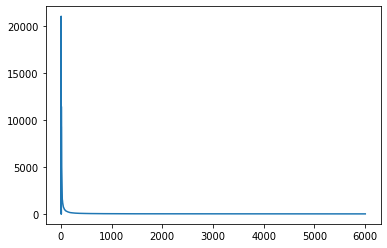

In [120]:
plt.plot(A.sum(axis=0))

### **Question 1 : is this distribution REALLY decreasing?**

#### The iteration below gives the answer; it IS decreasing, except for few early indices.

In [121]:
id2counts = A.sum(axis=0)
for i, _ in enumerate(id2counts[:-1]):
    if id2counts[i] < id2counts[i+1]:
        print(i)

1
4
8


#### The non-decreasing early indices are due to the pre-allocated special tokens.

In [122]:
for count, token in zip(A.sum(axis=0)[:10], movie_reviews.vocab.itos[:10]):
    print(f"{token:7} {count:.0f}")

xxunk   13624
xxpad   0
xxbos   800
xxeos   0
xxfld   0
xxmaj   21008
xxup    1582
xxrep   110
xxwrep  1
the     11410


### **Question 2: if not increasing, WHEN does it decreases?**

#### `dec_idxs` holds the index on which `id2counts == A.sum(axis=0)` strictly decreases. We observe a prominent accordance between starting points of the ripple pattern and decreasing indices.

In [123]:
dec_idxs = []
for i, _ in enumerate(id2counts[:-1]):
    if id2counts[i] > id2counts[i+1]:
        dec_idxs.append(i)

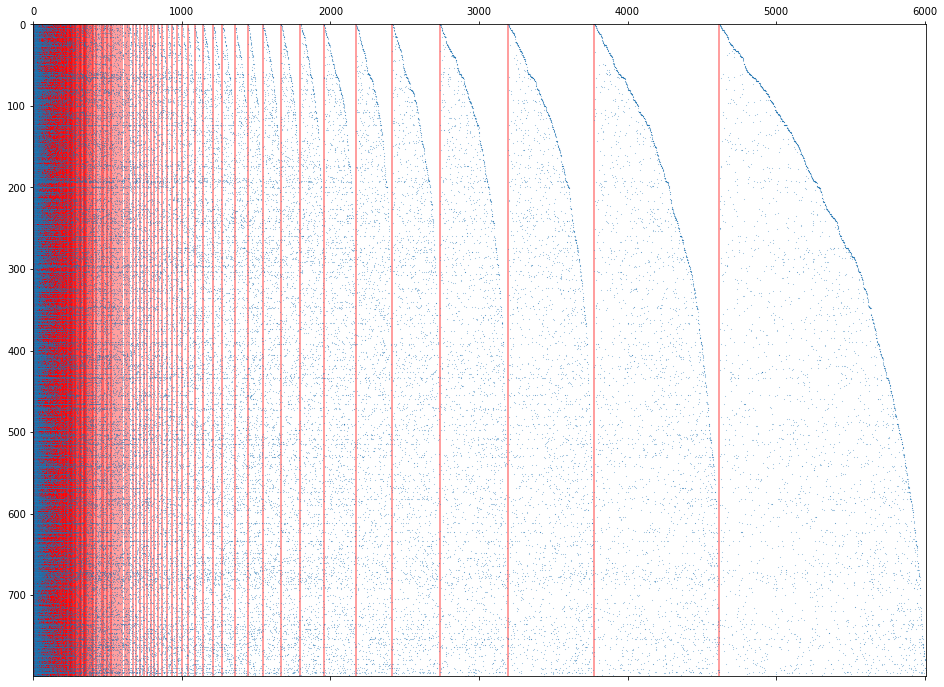

In [124]:
fig = plt.figure()
for idx in dec_idxs:
    plt.axvline(idx, c='red', alpha=0.5)
plt.spy(A, markersize=0.10, aspect = 'auto')
fig.set_size_inches(16,12)

#### the decreasing indices gets sparser for large index. That means for large indices, \# of occurrence stays the same for a long time.

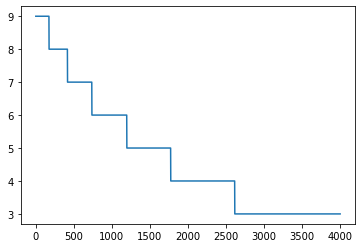

In [125]:
plt.plot(id2counts[2000:])

#### **Insights: Why do decreasing indices correlates with every STARTING point?**

#### That means, for each occurrence interval, the word included in *first row(sentence)* occurs at the very first of the interval.

#### **Hypothesis: What if the indices are sorted not only by counts, but also by the time of occurrence?**

#### For example, tokens in index 3800 ~ 4700 has occurred exactly 4 times throughout the whole (train) dataset. Among these 4-time words, words that are contained in upper rows (i.e. sentences occurred in the dataset early) gets registered in `Counter` earlier. As each sentence in the dataset is processed, more words get registered and are allocated to subsequent indices.

#### Since each sentences in the dataset are processed one after the other, and the index of each terms(tokens) are allocated AFTER the whole tokenizing & counting is performed (necessary to explain strict decreasing of counts), the hypothesis explains the ripply-boundary pattern.



#### Refer to the [Python docs for `Counter.most_common`:](https://docs.python.org/3/library/collections.html#collections.Counter.most_common)

> **most_common([n])**
>
> Return a list of the n most common elements and their counts from the most common to the least. If n is omitted or None, most_common() returns all elements in the counter. _**Elements with equal counts are ordered in the order first encountered.**_

#### The behaviour of `Counter` matches my hypothesis.

## Reconstruction

#### To ensure the suggested hypothesis, Let's generate the analogous pattern from synthetic data.

In [126]:
import numpy as np

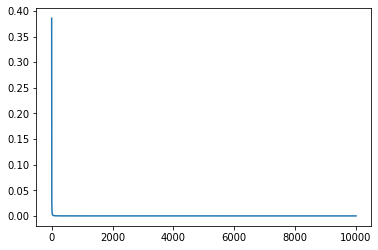

In [127]:
n_idxs, n_docs = 10000, 1000

# Probability array; to generate long-tail data, use power distribution.
# Other values of K yield different interesting pattern.
K = 1.5
p = np.arange(1, n_idxs+1, dtype='float') ** -K

p /= np.sum(p)
plt.plot(p)

# Shuffle to anonymize indices
np.random.shuffle(p)

In [128]:
# X is our synthetic data for tokenized sentences (movie_reviews.train.x)
# each number value stands for raw token string
X = np.random.choice(n_idxs, size=(n_docs, 800), p=p)
X[0]

array([4262, 4262, 5130, 7812, ..., 4262, 4262, 4262, 7812])

In [129]:
counter = Counter()

# Each row is processed one after the other.
for x in X:
    counter.update(x)

sorted_idxs = [ idx for idx, count in counter.most_common() ]

In [130]:
make_token_counter = lambda review_index: Counter(X[review_index])
def count_vectorizer(review_index,n_terms = n_idxs,make_token_counter = make_token_counter):
    # input: review index, n_terms, and tokenizer function
    # output: embedding vector for the review
    embedding_vector = np.zeros(n_terms)        
    keys = list(make_token_counter(review_index).keys())
    values = list(make_token_counter(review_index).values())
    embedding_vector[keys] = values
    return embedding_vector

# make the embedding vector for the first review
embedding_vector = count_vectorizer(0)

In [131]:
# Define a function to build the full document-term matrix
print(f'there are {n_docs} reviews, and {n_idxs} unique tokens in the vocabulary')
def make_full_doc_term_matrix(count_vectorizer,n_terms=n_idxs,n_docs=n_docs):
    
    # loop through the movie reviews
    for doc_index in range(n_docs):
        
        # make the embedding vector for the current review
        embedding_vector = count_vectorizer(doc_index,n_terms)    
            
        # append the embedding vector to the document-term matrix
        if(doc_index == 0):
            A = embedding_vector
        else:
            A = np.vstack((A,embedding_vector))
            
    # return the document-term matrix
    return A

# Build the full document term matrix for the movie_reviews training set
A = make_full_doc_term_matrix(count_vectorizer)

there are 1000 reviews, and 10000 unique tokens in the vocabulary


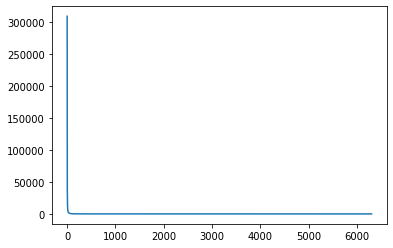

In [134]:
# Rather than mapping raw token to index and redefining X,
# we treat X's entries as generic indices and count to yield A,
# then reindex A to reverse order.
A_index_sorted = A[:, sorted_idxs]
sorted_count = A_index_sorted.sum(axis=0)
plt.plot(sorted_count)

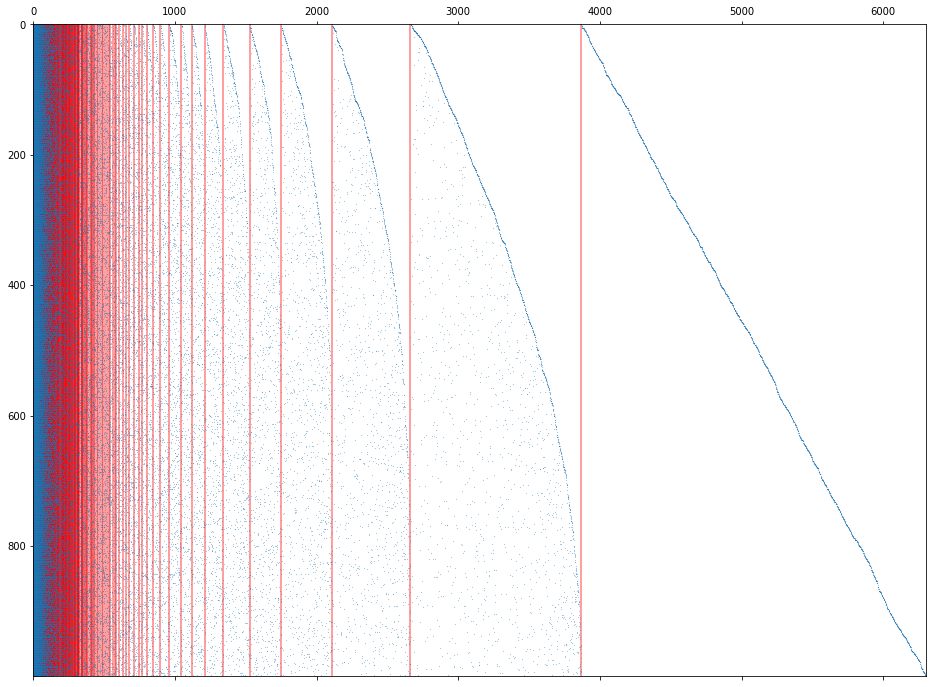

In [136]:
fig = plt.figure()
for i, _ in enumerate(sorted_count[:-1]):
    if sorted_count[i] > sorted_count[i+1]:
        plt.axvline(i, c='red', alpha=0.5)
plt.spy(A_index_sorted, markersize=0.10, aspect = 'auto')
fig.set_size_inches(16,12)

#### We can observe that similar pattern arises in synthetic data.

## Recap

#### The ripple pattern arises due to 2 main factor:

1. Long-tailed, decreasing distribution of tokens
- From this distribution occurs flat, constant plateau in rear part of occurence counts.

2. `Counter`'s behavior: conserving order of occurence when sorting
- When calculating `most_common()`, the order is conserved, thus the row number and index is (periodically) aligned.